In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql import DataFrameNaFunctions as DFna
from pyspark.sql.functions import udf, col, when
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [2]:
import socket

def get_Host_name_IP():
    try:
        host_name = socket.gethostname()
        host_ip = socket.gethostbyname(host_name)
        print("Hostname : ", host_name)
        print("ID : ", host_ip)
    except:
        print("enable to get hostname and ip")

get_Host_name_IP()

Hostname :  DESKTOP-4MJH10P
ID :  192.168.56.1


In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
ratingsData = spark.read.csv('ratings.csv',
                         header=True, 
                         quote='"',     
                         sep=",",        
                         inferSchema=True)  
ratingsData.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [5]:
ratingsData.toPandas().head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [6]:
ratingsRDD=ratingsData.select(col("user_id").cast("int"),col("book_id").cast("int"),col("rating").cast("int"))

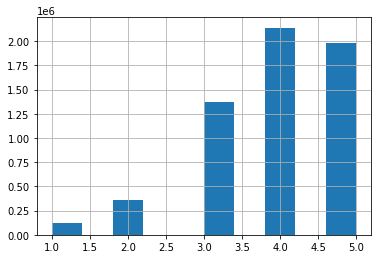

In [7]:
ratingsRDD.toPandas()['rating'].hist()
plt.show()

In [8]:
(ratings_train, ratings_test) = ratingsRDD.randomSplit([0.7,0.3],seed=5011)

In [9]:
numbers=range(0,2)
iterations = [5,8,10]
ranks = [1,2,3]
lambdas=[0.01,0.1]
errors = []
min_error = float('inf')
best_rank = -1
best_iteration = -1
best_lambda = -1
for j in numbers:
    for iteration in iterations:
        for rank in ranks:
            als = ALS(maxIter=iteration, regParam=lambdas[j], rank=rank, userCol="user_id", itemCol="book_id", ratingCol="rating")
            model = als.fit(ratings_train)
            predictions = model.transform(ratings_test)
            new_predictions = predictions.filter(col('prediction') != np.nan)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
            rmse = evaluator.evaluate(new_predictions)
            mse = rmse*rmse
            errors.append(rmse)

            print("rank: ",rank,"iteration: ",iteration,"lambda: ",lambdas[j],"rmse: ",rmse,"mse: ",mse)
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_iteration = iteration
                best_lambda = lambdas[j]
print("best rank: ",best_rank,"best iteration: ",best_iteration,"best lambda: ",best_lambda)

rank:  1 iteration:  5 lambda:  0.01 rmse:  0.861462938018098 mse:  0.7421183935787734
rank:  2 iteration:  5 lambda:  0.01 rmse:  0.8399685943574555 mse:  0.7055472395068396
rank:  3 iteration:  5 lambda:  0.01 rmse:  0.8489453660945375 mse:  0.7207082346133883
rank:  1 iteration:  8 lambda:  0.01 rmse:  0.8593104736956527 mse:  0.7384144902030471
rank:  2 iteration:  8 lambda:  0.01 rmse:  0.8362009173226375 mse:  0.6992319741312204
rank:  3 iteration:  8 lambda:  0.01 rmse:  0.835836462661053 mse:  0.6986225923137419
rank:  1 iteration:  10 lambda:  0.01 rmse:  0.858818039643558 mse:  0.7375684252172039
rank:  2 iteration:  10 lambda:  0.01 rmse:  0.8355538210856466 mse:  0.6981501879308247
rank:  3 iteration:  10 lambda:  0.01 rmse:  0.8343379073656149 mse:  0.6961197436672333
rank:  1 iteration:  5 lambda:  0.1 rmse:  0.8666173041702795 mse:  0.7510255518873628
rank:  2 iteration:  5 lambda:  0.1 rmse:  0.8458292738429611 mse:  0.7154271604897109
rank:  3 iteration:  5 lambda:  0.

In [10]:
final_als = ALS(maxIter=10, regParam=0.01, rank=3, userCol="user_id", itemCol="book_id", ratingCol="rating")
final_model = final_als.fit(ratings_train)
final_pred = final_model.transform(ratings_test)
final_pred = final_pred.filter(col('prediction') != np.nan)
rmse = evaluator.evaluate(final_pred)
mse = rmse*rmse
print("root mean squared error : ",rmse)
print("mean squared error : ",mse)

root mean squared error :  0.8343379073656149
mean squared error :  0.6961197436672333


In [11]:
final_pred.take(10)

[Row(user_id=6397, book_id=148, rating=4, prediction=3.7223243713378906),
 Row(user_id=9427, book_id=148, rating=3, prediction=3.6213538646698),
 Row(user_id=10206, book_id=148, rating=5, prediction=3.7839243412017822),
 Row(user_id=20924, book_id=148, rating=3, prediction=3.6558005809783936),
 Row(user_id=28124, book_id=148, rating=5, prediction=4.00152587890625),
 Row(user_id=28170, book_id=148, rating=4, prediction=3.328535556793213),
 Row(user_id=35982, book_id=148, rating=3, prediction=3.431757926940918),
 Row(user_id=47217, book_id=148, rating=4, prediction=3.6324801445007324),
 Row(user_id=50223, book_id=148, rating=4, prediction=4.049578666687012),
 Row(user_id=14465, book_id=148, rating=5, prediction=4.356509208679199)]

In [12]:
from pyspark.sql.types import IntegerType

usersList = [148, 10567, 48367, 50223, 6397, 14465]

usersDF = spark.createDataFrame(usersList, IntegerType()).toDF("user_id")

usersDF.take(6)

[Row(user_id=148),
 Row(user_id=10567),
 Row(user_id=48367),
 Row(user_id=50223),
 Row(user_id=6397),
 Row(user_id=14465)]

In [13]:
userRecs = model.recommendForUserSubset(usersDF, 5)

userRecs.toPandas()

,user_id,recommendations
0,148,"[(8946, 4.5890398025512695), (3628, 4.47446870..."
1,6397,"[(862, 4.5771918296813965), (3628, 4.537082672..."
2,50223,"[(1338, 5.433267116546631), (4868, 5.393134593..."
3,14465,"[(862, 5.302934646606445), (3628, 5.2167997360..."
4,10567,"[(8946, 6.1116108894348145), (3628, 6.10078382..."
5,48367,"[(862, 6.271950721740723), (3628, 6.1940903663..."


In [14]:
userBooksList = userRecs.filter(userRecs.user_id == 6397).select("recommendations")

userBooksList.collect()

[Row(recommendations=[Row(book_id=862, rating=4.5771918296813965), Row(book_id=3628, rating=4.537082672119141), Row(book_id=6920, rating=4.513975620269775), Row(book_id=8946, rating=4.508277893066406), Row(book_id=9566, rating=4.502222537994385)])]

In [15]:
booksList = userBooksList.collect()[0].recommendations

booksList

[Row(book_id=862, rating=4.5771918296813965),
 Row(book_id=3628, rating=4.537082672119141),
 Row(book_id=6920, rating=4.513975620269775),
 Row(book_id=8946, rating=4.508277893066406),
 Row(book_id=9566, rating=4.502222537994385)]

In [16]:
booksDF = spark.createDataFrame(booksList)
booksDF.toPandas()

,book_id,rating
0,862,4.577192
1,3628,4.537083
2,6920,4.513976
3,8946,4.508278
4,9566,4.502223


In [17]:
booksData =  spark.read.csv('books.csv',
                         header=True, 
                         quote='"',     
                         sep=",",        
                         inferSchema=True)  
booksData.head()
booksData.printSchema()

root
 |-- book_id: integer (nullable = true)
 |-- goodreads_book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: string (nullable = true)
 |-- ratings_count: string (nullable = true)
 |-- work_ratings_count: string (nullable = true)
 |-- work_text_reviews_count: string (nullable = true)
 |-- ratings_1: double (nullable = true)
 |-- ratings_2: integer (nullable = true)
 |-- ratings_3: integer (nullable = true)
 |-- ratings_4: integer (nullable = true)
 |-- ratings_5: integer (nullable = true)
 |-- image_url: string (nullable = true)
 |-- small_image_url: string (nu

In [18]:
booksData = booksData.drop('goodreads_book_id','best_book_id','work_id','books_count','isbn','isbn13','original_publication_year','original_title','language_code','average_rating','ratings_count','work_ratings_count','work_text_reviews_count','ratings_1','ratings_2','ratings_3','ratings_4','ratings_5','image_url','small_image_url')
booksData.printSchema()

root
 |-- book_id: integer (nullable = true)
 |-- authors: string (nullable = true)
 |-- title: string (nullable = true)



In [19]:
booksData.toPandas().head()

,book_id,authors,title
0,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
1,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...
2,3,Stephenie Meyer,"Twilight (Twilight, #1)"
3,4,Harper Lee,To Kill a Mockingbird
4,5,F. Scott Fitzgerald,The Great Gatsby


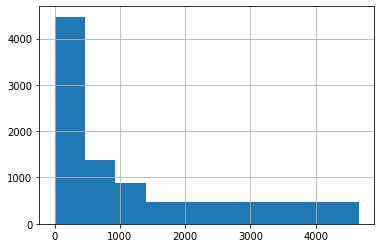

In [20]:
authorsIndexer = StringIndexer(inputCol="authors", outputCol="bookauthors",handleInvalid='error') 
authorsIndexed = authorsIndexer.fit(booksData).transform(booksData) 
booksInd = authorsIndexed.drop('authors')
booksInd.toPandas()['bookauthors'].hist()
plt.show()

In [21]:
recommendedBooks = booksData.join(booksDF, on=["book_id"]).orderBy("rating", ascending=False).select("authors", "title", "rating")

recommendedBooks.toPandas().head()

,authors,title,rating
0,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)",4.577192
1,Bill Watterson,The Complete Calvin and Hobbes,4.537083
2,Bill Watterson,The Indispensable Calvin and Hobbes,4.513976
3,Hafez,The Divan,4.508278
4,Bill Watterson,Attack of the Deranged Mutant Killer Monster S...,4.502223


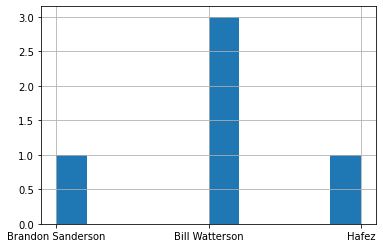

In [22]:
recommendedBooks.toPandas()['authors'].hist()
plt.show()

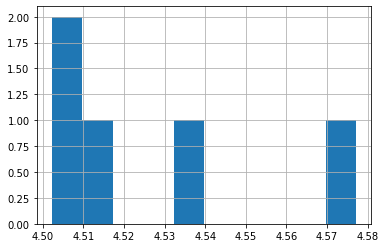

In [23]:
recommendedBooks.toPandas()['rating'].hist()
plt.show()

In [24]:
from pyspark.sql.types import IntegerType

def getRecommendationsForUser(userID, numRecs):

    usersDF = spark.    createDataFrame([userID], IntegerType()).    toDF("user_id")

    userRec = model.recommendForUserSubset(usersDF, numRecs)

    bookList = userRec.collect()[0].recommendations

    bookDF = spark.createDataFrame(bookList)

    recommendedBooks = booksData.join(bookDF, on=["book_id"])    .orderBy("rating",   ascending=False)    .select("authors", "title", "rating")

    return recommendedBooks

In [25]:
recommendationsForUser = getRecommendationsForUser(245, 10)

recommendationsForUser.toPandas()

,authors,title,rating
0,Bill Watterson,The Complete Calvin and Hobbes,4.419330
1,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)",4.411098
2,Hafez,The Divan,4.408051
3,Bill Watterson,Attack of the Deranged Mutant Killer Monster S...,4.404571
4,Bill Watterson,The Indispensable Calvin and Hobbes,4.399302
5,Bill Watterson,The Authoritative Calvin and Hobbes: A Calvin ...,4.376561
6,James E. Talmage,Jesus the Christ,4.356478
7,Brandon Sanderson,"The Way of Kings, Part 1 (The Stormlight Archi...",4.317127
8,J.K. Rowling,"Harry Potter Boxset (Harry Potter, #1-7)",4.316428
9,Bill Watterson,There's Treasure Everywhere: A Calvin and Hobb...,4.314927


In [26]:
recommendationsForUser = getRecommendationsForUser(1003, 5)

recommendationsForUser.toPandas()

,authors,title,rating
0,Hafez,The Divan,4.954007
1,George Saunders,Lincoln in the Bardo,4.663931
2,Roberto Bolaño,2666,4.545420
3,"Ludwig Wittgenstein, G.E.M. Anscombe",Philosophical Investigations,4.518527
4,"Nicholas Ganz, Tristan Manco",Graffiti World: Street Art from Five Continents,4.512042
